# Домашнее задание 2. Классификация изображений.

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as T
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(1984)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-08 18:52:32--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-08 18:52:33--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccfb10c7eef5953a7628a8415b0.dl.dropboxusercontent.com/cd/0/get/BwYAIwn3mxPA2GJ2BrQlxijHcn0xTTfU7zUDiErco625F1UgwYD7b0khoTCZCaESfaAPwir5q_MtoOyafwWdp2r9g7VwLiGVWq39F4mTWhlo-HOVYqozMfc1ugHv6IMxRTa5k8JmTURNgSJNRSiKPoOyZdnFlzHdO2gbDzGdsJL2tw/file?dl=1# [following]
--2022-11-08 18:52:33--  https://uccfb10c7eef5953a7628a8415b0.dl.dropboxusercontent.com/cd/0/get/BwYAIwn3mxPA2GJ2BrQlxijHcn0xTTfU7zUDiErco625F1UgwYD7b0khoTCZCaESfaAPwir5q_MtoO

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

### Подготовка данных

In [ ]:
# Примеры аугментаций взяты с https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

train_transform = T.Compose([T.ToTensor(),
      T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
      T.RandomHorizontalFlip(0.5),
      T.RandomPerspective(0.5, 0.5),
      ])  

# подсказка по средней и стд из чатика                                                                                          

val_transform = T.Compose([T.ToTensor(),
      T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

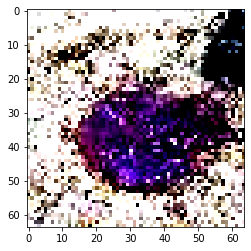

(256, 3, 64, 64)


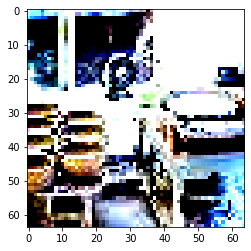

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    images = images
    plt.imshow(images[np.random.randint(0, 255)].permute(1, 2, 0))
    plt.show()
    npimg = images.numpy()
    print(npimg.shape)
    plt.imshow(images[np.random.randint(0, 255)].permute(1, 2, 0))
    plt.show()
    
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
from torchvision.models import densenet121

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super(YourNet, self).__init__()
        
        # размер больше 29х29, значит подойдет модель из 
        # https://arxiv.org/abs/1608.06993

        self.model = densenet121(num_classes=200, weights=None)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        return self.model(x)

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss
    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

model = YourNet().to(device)

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        
    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
        
        # в https://arxiv.org/abs/1608.06993 рекомендуется снижать lr при отсутствии падения ошибки
        
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
       } # https://github.com/Lightning-AI/lightning/issues/4454

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

module = YourModule(model, learning_rate=0.001)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
wandb.finish()
wandb_logger = WandbLogger(log_model='all')

wandb: Currently logged in as: sir_kolbas. Use `wandb login --relogin` to force relogin


In [ ]:
seed_everything(1984)
trainer = pl.Trainer(auto_select_gpus=False, 
                     accelerator='cuda', max_epochs=13, 
                     logger=wandb_logger, auto_lr_find=True, 
                     log_every_n_steps=50
                     ) 

trainer.fit(module, train_dataloader, val_dataloader) 

torch.save(model.state_dict(), '/content/model.pth')

# подсказка по сохранению модели из чатика

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | YourNet | 7.2 M 
----------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=13` reached.


### Валидация результатов задания

In [ ]:
model = YourNet().to(device) # Переобозначаю модель 
model.load_state_dict(torch.load('/content/model.pth')) # И загружаю ранее предобученную мною модель

<All keys matched successfully>

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()

    predlab = torch.Tensor([]).to(device)
    factlab = torch.Tensor([]).to(device)

    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            
            dummy = torch.argmax(model._forward(images), dim=-1)
            
            predlab = torch.cat((predlab, dummy), 0)
            factlab = torch.cat((factlab, labels), 0)
        
    return accuracy_score(predlab.cpu().detach().numpy(), factlab.cpu().detach().numpy())

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"accuracy {accuracy}")
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 40/40 [00:03<00:00, 10.26it/s]

accuracy 0.4806
Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

In [ ]:
# В стандартном торчвижн.трансформ нет функции, добавляющей шум

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# За реализацию Гаусова шума спасибо админам пайторча 
# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745

In [ ]:
train_transform = T.Compose([T.ToTensor(),    
    T.Resize((256, 256)), T.CenterCrop(224),
    #T.RandomCrop(224),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    T.RandomHorizontalFlip(), T.RandomAdjustSharpness(1.5, 0.3),  
    T.ColorJitter(0.5, 0.4, 0.2, 0.3),
    #T.RandomApply([AddGaussianNoise(0., 1.)], 0.5),
    ])

val_transform = T.Compose([T.ToTensor(),
    T.Resize((256, 256)), T.CenterCrop(224),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Модель (или просто импортируйте предобученную)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from torchvision.models import convnext_large
model1 = convnext_large(weights='DEFAULT')
model1
# в предпоследнем слое выход - 1536, добавлю полносвязный с выходом 200

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(YourNet, self).__init__()
        
        self.model = convnext_large(weights='DEFAULT')
        self.model.classifier = nn.Identity() # Deletes last layer
        self.classifier = nn.Sequential(
              nn.Flatten(start_dim=1, end_dim=-1),
              nn.Linear(in_features=1536, out_features=200, bias=True))

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # так как лучшие веса уже подобраны, я не буду обучать модель, а
        # просто ее использую (обучив лишь последний полносвязный слой)
        with torch.no_grad():
          features = self.model(x)
        preds = self.classifier(features)
        return preds

    def forward(self, images, target=None):
        
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss
    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

model = YourNet().to(device)

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model):
        
        super().__init__()
        self.model = model
        self.save_hyperparameters()

        
    def forward(self, x) -> torch.Tensor:
        
        preds = self.model(x)
        
        return preds

    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.model.classifier.parameters())
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1)

        return optimizer
        #{
         #  'optimizer': optimizer,
          # 'lr_scheduler': scheduler,
           #'monitor': 'val_loss'
       #}
       

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

module = YourModule(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
wandb.finish()
wandb_logger = WandbLogger(log_model='all')

In [ ]:
trainer = pl.Trainer(accelerator='cuda', max_epochs=1, logger=wandb_logger)  
trainer.fit(module, train_dataloader, val_dataloader) 

In [ ]:
torch.save(model.state_dict(), '/content/model1.pth')

### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()

    predlab = torch.Tensor([]).to(device)
    factlab = torch.Tensor([]).to(device)

    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            
            dummy = torch.argmax(model._forward(images), dim=-1)
            
            predlab = torch.cat((predlab, dummy), 0)
            factlab = torch.cat((factlab, labels), 0)
        
    return accuracy_score(predlab.cpu().detach().numpy(), factlab.cpu().detach().numpy())

In [ ]:
model = YourNet().to(device)
model.load_state_dict(torch.load('/content/model1.pth'))
accuracy = evaluate_task(model, val_dataloader)
print(f"accuracy {accuracy}")
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

In [ ]:
"""
Начал все с подбора модели отсюда
https://pytorch.org/vision/stable/models.html
Искал такую, которая бы давала максимальный акураси при приемлимом количестве обучаемых параметров,
так как мне предстояло их обучать с нуля на всего 4гб графической памяти колаба.
Подобрал денснет121. 

Затем начал подбирать разные сопосбы аугментации, начиная с 
библиотеки албументэйшнс, но с сложными аугментациями оттуда модель недообучалось, поэтому
в первом задании решил ограничиться примитивными аугментацями из торча. 

Для второго задания использовал также аугментации из торч.трансформ, а точнее отсюда:
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
и сюда https://pytorch.org/vision/stable/transforms.html

Для второй модели также подбирал модель с максимальным акураси, но уже не обращая столь
пристального внимания на количество параметров, так как обучать их не придеться.

Пробовал разные оптимизаторы, из двух (адам и моментум) лучше себя показал 1й

Пробовал также разные шедулеры, из списка COSINEANNEALINGLR, степ, плато; лучше 
всех себя показал последний.
"""